## Imports

*Please see the markdown reports at the very end of the file.*

**For the state, please refer to https://drive.google.com/file/d/1raej3l35vJE8ukXc-8iCllPZ6AXs6CA9/view?usp=sharing**

In [1]:
import numpy as np
import pickle
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.nn import functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from tqdm.auto import tqdm
from PIL import Image
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class MyDataset(Dataset):

    def __init__(self, folders, transform=None):
        self.folders, self.labels = self.get_labels(folders)
        self.transform = transform

    def __len__(self):
        return len(self.folders)
    
    def __getitem__(self, idx):
        folder_id = self.folders[idx]
        
        try:
            with open(folder_id, 'rb') as f:
                color_img = pickle.load(f)
        except EOFError:
            print(folder_id)

        # img process
        #for i in range(color_img.shape[0]):
        #    if np.ptp(color_img[i, :, :]) != 0:
        #        color_img[i,:,:] = (color_img[i,:,:] - np.min(color_img[i,:,:])) / np.ptp(color_img[i,:,:])
        color_img = color_img.transpose((1,2,0))

        # img process
        c1 = color_img[:,:,0]
        c2 = color_img[:,:,1]
        c3 = color_img[:,:,2]
        c4 = color_img[:,:,3]
        
        c1 = np.expand_dims(c1, axis=2)
        c2 = np.expand_dims(c2, axis=2)
        c3 = np.expand_dims(c3, axis=2)
        c4 = np.expand_dims(c4, axis=2)

        color_img = np.concatenate((c1, c2, c3, c4), axis=2)
        #for i in range(color_img.shape[2]):
        #    if np.ptp(color_img[:,:,i]) == 0:
         #       continue
         #   color_img[:,:,i] = (color_img[:,:,i] - np.min(color_img[:,:,i])) / np.ptp(color_img[:,:,i])

        # img process, tranform
        if self.transform is not None:
            color_img = np.uint8(255*color_img)
            color_img = Image.fromarray(color_img)
            color_img = self.transform(color_img)

        return color_img, self.labels[idx]


    def get_labels(self, folders):

        files = []
        labels = []

        #conding=utf8  
        g = os.walk(folders)  

        for path, _, file_list in g:  
            for file_name in file_list:
                files.append(os.path.join(path, file_name))
                if 'nil_HS_H08' in file_name or 'light_HS_H08' in file_name:
                    labels.append(0)
                elif 'moderate_HS_H08' in file_name:
                    labels.append(1)
                else:
                    labels.append(2)
                
        return files, labels

## Transform raw data

In [4]:
pre_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    #transforms.RandomCrop(200),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomAffine(30),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [5]:
train_dataset = MyDataset("./drive/MyDrive/proj1_data/train",pre_transform)
val_dataset = MyDataset("./drive/MyDrive/proj1_data/validate",val_transform)

## Load Data

In [6]:
print("train data length: %d  valid data length % d"%(len(train_dataset),len(val_dataset)))

train data length: 1754  valid data length  306


## Visualize Traning Data

In [ ]:
img,label = train_dataset[0]
if (label == 0):
    print("This is class nil")
elif (label == 1):
    print("This is class MOD")
else:
    print("This is class SEV")

Band8 = img[0][:][:]
Band12 = img[1][:][:]
Band13 = img[2][:][:]
Band14 = img[3][:][:]
Band = [Band8,Band12,Band13,Band14]

for i in range(1,5):
    plt.subplot(2,2,i)
    plt.imshow(Band[i-1])
plt.show()

In [ ]:
#Calculate the number of samples in differnet class
train_nil_count = 0   ##591
train_MOD_count = 0   ##839
train_SEV_count = 0   ##324
valid_nil_count = 0   ##192
valid_MOD_count = 0   ##81
valid_SEV_count = 0   ##33

for i in range (0,1754):
    #print(i)
    img, label = train_dataset[i]
    if (label == 0):
        train_nil_count += 1
    elif (label == 1):
        train_MOD_count += 1
    else:
        train_SEV_count += 1
print("train set has %d nil, %d MOD, %d SEV" %(train_nil_count, train_MOD_count, train_SEV_count))

for i in range (0,306):
    #print(i)
    img, label = val_dataset[i]
    if (label == 0):
        valid_nil_count += 1
    elif (label == 1):
        valid_MOD_count += 1
    else:
        valid_SEV_count += 1
print("valid set has %d nil, %d MOD, %d SEV" %(valid_nil_count, valid_MOD_count, valid_SEV_count))

## Define Model & Loss

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, 3, 1, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.fc1 = nn.Linear(64*28*28, 2048)
        self.fc2 = nn.Linear(2048, 100)
        self.fc3 = nn.Linear(100, 3)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm23 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.1)
        self.batchnorm3 = nn.BatchNorm1d(2048)
        self.batchnorm4 = nn.BatchNorm1d(100)
        self.batchnorm5 = nn.BatchNorm1d(3)
        
    def forward(self, x):
        # x's shape = N * 4 * 224 * 224, where N is batch size
        x = self.conv1(x)
        # x's shape = N * 16 * 224 * 224
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # x's shape = N * 16 * 112 * 112
        x = self.conv2(x)
        # x's shape = N * 32 * 112 * 112
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # x's shape = N * 32 * 56 * 56
        x = self.conv3(x)
        x = self.batchnorm23(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1) # flat starts from the second dim
        # x's shape = N * (32 * 56 * 56) = N * 100352
        x = self.fc1(x)
        # x's shape =  N * 128
        x = self.batchnorm3(x)
        x = F.relu(x)
        # x =  self.dropout(x)
        # x's shape =  N * 128
        # x = self.dropout(x)
        x = self.fc2(x)
        x = self.batchnorm4(x)
        x = F.relu(x)
        # x's shape =  N * 3
        # x =  self.dropout(x)
        x = self.fc3(x)
        x = self.batchnorm5(x)
        # x = F.relu(x)
        # x's shape =  N * 3
        # x =  self.dropout(x)
        return x

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, pin_memory=False)

In [9]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=3, bias=True)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm23): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(3, eps=1e-05, momentum

In [10]:
criterion = nn.CrossEntropyLoss()

## LDAM Loss

In [ ]:
class LDAMLoss(nn.Module):
    
    def __init__(self, cls_num_list, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        self.m_list = m_list
        assert s > 0
        self.s = s
        self.weight = weight

    def forward(self, x, target):
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.cuda.FloatTensor)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight)

In [ ]:
def LDAMLoss(output, target, n_class_nil, n_class_MOD, n_class_SEV, C):
    loss = 0
    n_class = [n_class_nil, n_class_MOD, n_class_SEV]
    #output_class = output.argmax(dim=1, keepdim=False) #Shape [64], the predict class
    niter = output.shape[0] # 64 for a batch
    for i in range(niter):
        Z_y = output[i][target[i]]
        delta_y = C / (n_class[target[i]] ** (0.25) )
        nominator = torch.exp(Z_y - delta_y)
        if (target[i] == 0):
            dinominator = nominator + torch.exp(output[i][1]) + torch.exp(output[i][2])
        elif (target[i] == 1):
            dinominator = nominator + torch.exp(output[i][0]) + torch.exp(output[i][2])
        else:
            dinominator = nominator + torch.exp(output[i][0]) + torch.exp(output[i][1])
        loss += (-torch.log(nominator/dinominator))
    return loss

In [11]:
def compute_acc(outputs, targets):
    preds = outputs.argmax(dim=1, keepdim=True)
    return preds.eq(targets.view_as(preds)).sum().item() / targets.shape[0]

In [12]:
def performance_eval(outputs, targets):
    preds = outputs.argmax(dim=1, keepdim=False)
    targets = targets.view_as(preds)
    performance_dict = {"NIL":0.0,"MOD":0.0, "SEV":0.0 }
    for i in range(3):
        TP = targets[preds.eq(i)].eq(i).sum().item()
        FP = (~targets[preds.eq(i)].eq(i)).sum().item()
        FN = (~preds[targets.eq(i)].eq(i)).sum().item()
        Precision =  torch.true_divide(TP,(TP + FP))
        Recall = torch.true_divide(TP,(TP + FN))
        F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
        performance_dict[list(performance_dict.keys())[i]] = torch.tensor([Precision,Recall,F1])
    return performance_dict

In [13]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        self.TP = torch.tensor([0,0,0])
        self.FP = torch.tensor([0,0,0])
        self.FN = torch.tensor([0,0,0])
        
    def update(self, val, outputs, targets, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt
        preds = outputs.argmax(dim=1, keepdim=True)
        preds = preds.view(-1)
        targets = targets.view(-1)
        for i in range(3):
            self.TP[i] += targets[preds.eq(i)].eq(i).sum().item()
            self.FP[i] += (~targets[preds.eq(i)].eq(i)).sum().item()
            self.FN[i] += (~preds[targets.eq(i)].eq(i)).sum().item()

In [14]:
model = model.cuda()
criterion = criterion.cuda()

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
def train_one_epoch(inputs, targets, optimizer):
    # accs = AverageMeter()
    # for X, y in tqdm(train_loader, leave=False):
    # inputs = X.cuda()
    # targets = y.cuda()
    #inputs = X
    #targets = y
    optimizer.zero_grad()
    # forward
    outputs = model(inputs)
    #loss =  LDAMLoss(outputs,targets,591,839,324,C = 1.0)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    # accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
        
    return loss, outputs 

In [17]:
def validate_one_epoch(inputs, targets):
    accs = AverageMeter()
    # for X, y in tqdm(val_loader, leave=False):
    # inputs = X.cuda()
    # targets = y.cuda()
    #inputs = X
    #targets = y
    #optimizer.zero_grad()
    # forward
    outputs = model(inputs)
    #loss = criterion(outputs, targets)
    loss = criterion(outputs, targets)

    #loss.backward()
    #optimizer.step()
    accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
    return loss, outputs  

In [18]:
best_epoch = -1
best_acc = 0.0
best_model_state = model.state_dict()
history_train_acc = []
history_val_acc = []

scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in tqdm(range(50)):
    for phase in range (0,2):
        if phase == 0:
            model.train()
            accs = AverageMeter()
            for X, y in tqdm(train_loader, leave=False):
                inputs = Variable(X.cuda())
                targets = Variable(y.cuda())
                loss, outputs = train_one_epoch(inputs, targets, optimizer)
                accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
            print("epoch {} train acc: {:.4f} ".format(epoch, accs.avg))
            class_names = ["NIL","MOD","SEV"]
            scheduler.step()
            for i in range(3):
                Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
                Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
                F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
                print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))
            history_train_acc.append(accs)
            
        elif phase == 1:
            model.eval()
            accs = AverageMeter()
            for X, y in tqdm(val_loader, leave=False):
                inputs = Variable(X.cuda())
                targets = Variable(y.cuda())
                loss, outputs = validate_one_epoch(inputs, targets)
                accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
            print("epoch {} valid acc: {:.4f} ".format(epoch, accs.avg))
            class_names = ["NIL","MOD","SEV"]
            for i in range(3):
                Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
                Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
                F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
                print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))
            history_val_acc.append(accs)
            
            if accs.avg > best_acc:
                best_acc = accs.avg
                best_epoch = epoch
                best_model_state = model.state_dict()   
            
print(f'[Info] best val acc: {best_acc:.2%} at {best_epoch+1}th epoch')

epoch 0 train acc: 0.5410 
class NIL Precision 0.691 Recall0.567 F1 0.623
class MOD Precision 0.651 Recall0.530 F1 0.584
class SEV Precision 0.289 Recall0.522 F1 0.372


epoch 0 valid acc: 0.6275 
class NIL Precision 0.627 Recall1.000 F1 0.771
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 1 train acc: 0.9105 
class NIL Precision 0.879 Recall0.920 F1 0.899
class MOD Precision 0.966 Recall0.906 F1 0.935
class SEV Precision 0.842 Recall0.904 F1 0.872


epoch 1 valid acc: 0.7320 
class NIL Precision 0.716 Recall0.958 F1 0.820
class MOD Precision 0.780 Recall0.395 F1 0.525
class SEV Precision 1.000 Recall0.242 F1 0.390


epoch 2 train acc: 0.9897 
class NIL Precision 0.988 Recall0.995 F1 0.992
class MOD Precision 0.996 Recall0.986 F1 0.991
class SEV Precision 0.976 Recall0.991 F1 0.983


epoch 2 valid acc: 0.7745 
class NIL Precision 0.943 Recall0.776 F1 0.851
class MOD Precision 0.808 Recall0.728 F1 0.766
class SEV Precision 0.387 Recall0.879 F1 0.537


epoch 3 train acc: 0.9977 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall0.997 F1 0.995


epoch 3 valid acc: 0.7941 
class NIL Precision 0.980 Recall0.755 F1 0.853
class MOD Precision 0.624 Recall0.901 F1 0.737
class SEV Precision 0.610 Recall0.758 F1 0.676


epoch 4 train acc: 0.9989 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.998 F1 0.999
class SEV Precision 0.997 Recall1.000 F1 0.998


epoch 4 valid acc: 0.8105 
class NIL Precision 0.800 Recall0.938 F1 0.863
class MOD Precision 0.800 Recall0.642 F1 0.712
class SEV Precision 1.000 Recall0.485 F1 0.653


epoch 5 train acc: 0.9971 
class NIL Precision 0.997 Recall1.000 F1 0.998
class MOD Precision 0.999 Recall0.995 F1 0.997
class SEV Precision 0.994 Recall0.997 F1 0.995


epoch 5 valid acc: 0.8137 
class NIL Precision 0.963 Recall0.807 F1 0.878
class MOD Precision 0.608 Recall0.938 F1 0.738
class SEV Precision 0.900 Recall0.545 F1 0.679


epoch 6 train acc: 0.9977 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall0.997 F1 0.995


epoch 6 valid acc: 0.7549 
class NIL Precision 0.992 Recall0.688 F1 0.812
class MOD Precision 0.530 Recall0.975 F1 0.687
class SEV Precision 0.833 Recall0.606 F1 0.702


epoch 7 train acc: 0.9977 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.998 Recall0.998 F1 0.998
class SEV Precision 0.997 Recall0.994 F1 0.995


epoch 7 valid acc: 0.8007 
class NIL Precision 0.962 Recall0.781 F1 0.862
class MOD Precision 0.585 Recall0.938 F1 0.720
class SEV Precision 0.950 Recall0.576 F1 0.717


epoch 8 train acc: 0.9977 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall0.997 F1 0.995


epoch 8 valid acc: 0.8105 
class NIL Precision 0.957 Recall0.802 F1 0.873
class MOD Precision 0.603 Recall0.938 F1 0.734
class SEV Precision 0.947 Recall0.545 F1 0.692


epoch 9 train acc: 0.9971 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.998 Recall0.996 F1 0.997
class SEV Precision 0.994 Recall0.994 F1 0.994


epoch 9 valid acc: 0.8333 
class NIL Precision 0.952 Recall0.833 F1 0.889
class MOD Precision 0.636 Recall0.926 F1 0.754
class SEV Precision 1.000 Recall0.606 F1 0.755


epoch 10 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.998 Recall0.999 F1 0.998
class SEV Precision 1.000 Recall0.994 F1 0.997


epoch 10 valid acc: 0.7157 
class NIL Precision 0.992 Recall0.635 F1 0.775
class MOD Precision 0.491 Recall0.975 F1 0.653
class SEV Precision 0.818 Recall0.545 F1 0.655


epoch 11 train acc: 0.9989 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.998 F1 0.999
class SEV Precision 0.997 Recall1.000 F1 0.998


epoch 11 valid acc: 0.7778 
class NIL Precision 0.986 Recall0.729 F1 0.838
class MOD Precision 0.552 Recall0.975 F1 0.705
class SEV Precision 0.905 Recall0.576 F1 0.704


epoch 12 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.998 F1 0.998
class SEV Precision 0.997 Recall0.997 F1 0.997


epoch 12 valid acc: 0.7549 
class NIL Precision 0.992 Recall0.688 F1 0.812
class MOD Precision 0.530 Recall0.975 F1 0.687
class SEV Precision 0.833 Recall0.606 F1 0.702


epoch 13 train acc: 0.9989 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.998 F1 0.999
class SEV Precision 0.997 Recall1.000 F1 0.998


epoch 13 valid acc: 0.7843 
class NIL Precision 0.986 Recall0.740 F1 0.845
class MOD Precision 0.564 Recall0.975 F1 0.715
class SEV Precision 0.864 Recall0.576 F1 0.691


epoch 14 train acc: 0.9977 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall0.997 F1 0.995


epoch 14 valid acc: 0.7778 
class NIL Precision 0.986 Recall0.724 F1 0.835
class MOD Precision 0.560 Recall0.975 F1 0.712
class SEV Precision 0.833 Recall0.606 F1 0.702


epoch 15 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.998 F1 0.998
class SEV Precision 0.997 Recall0.997 F1 0.997


epoch 15 valid acc: 0.7647 
class NIL Precision 0.993 Recall0.714 F1 0.830
class MOD Precision 0.537 Recall0.975 F1 0.693
class SEV Precision 0.857 Recall0.545 F1 0.667


epoch 16 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.998 F1 0.998
class SEV Precision 0.997 Recall0.997 F1 0.997


epoch 16 valid acc: 0.7647 
class NIL Precision 0.993 Recall0.703 F1 0.823
class MOD Precision 0.545 Recall0.975 F1 0.699
class SEV Precision 0.800 Recall0.606 F1 0.690


epoch 17 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.998 F1 0.998
class SEV Precision 0.997 Recall0.997 F1 0.997


epoch 17 valid acc: 0.7549 
class NIL Precision 0.992 Recall0.688 F1 0.812
class MOD Precision 0.530 Recall0.975 F1 0.687
class SEV Precision 0.833 Recall0.606 F1 0.702


epoch 18 train acc: 0.9971 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.998 Recall0.996 F1 0.997
class SEV Precision 0.994 Recall0.994 F1 0.994


epoch 18 valid acc: 0.7712 
class NIL Precision 0.986 Recall0.724 F1 0.835
class MOD Precision 0.549 Recall0.975 F1 0.702
class SEV Precision 0.857 Recall0.545 F1 0.667


epoch 19 train acc: 0.9989 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.998 F1 0.999
class SEV Precision 0.997 Recall1.000 F1 0.998


epoch 19 valid acc: 0.7647 
class NIL Precision 0.993 Recall0.714 F1 0.830
class MOD Precision 0.537 Recall0.975 F1 0.693
class SEV Precision 0.857 Recall0.545 F1 0.667


epoch 20 train acc: 0.9977 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall0.997 F1 0.995


epoch 20 valid acc: 0.7843 
class NIL Precision 0.986 Recall0.734 F1 0.842
class MOD Precision 0.564 Recall0.975 F1 0.715
class SEV Precision 0.870 Recall0.606 F1 0.714


epoch 21 train acc: 0.9989 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.998 F1 0.999
class SEV Precision 0.997 Recall1.000 F1 0.998


epoch 21 valid acc: 0.7680 
class NIL Precision 0.986 Recall0.714 F1 0.828
class MOD Precision 0.545 Recall0.975 F1 0.699
class SEV Precision 0.864 Recall0.576 F1 0.691


epoch 22 train acc: 0.9989 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.999 F1 0.999
class SEV Precision 1.000 Recall0.997 F1 0.998


epoch 22 valid acc: 0.7876 
class NIL Precision 0.986 Recall0.740 F1 0.845
class MOD Precision 0.572 Recall0.975 F1 0.721
class SEV Precision 0.833 Recall0.606 F1 0.702


epoch 23 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall1.000 F1 0.997


epoch 23 valid acc: 0.7549 
class NIL Precision 0.993 Recall0.698 F1 0.820
class MOD Precision 0.527 Recall0.975 F1 0.684
class SEV Precision 0.857 Recall0.545 F1 0.667


epoch 24 train acc: 0.9977 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall0.997 F1 0.995


epoch 24 valid acc: 0.7647 
class NIL Precision 0.993 Recall0.714 F1 0.830
class MOD Precision 0.537 Recall0.975 F1 0.693
class SEV Precision 0.857 Recall0.545 F1 0.667


epoch 25 train acc: 0.9989 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.998 F1 0.999
class SEV Precision 0.997 Recall1.000 F1 0.998


epoch 25 valid acc: 0.7647 
class NIL Precision 0.993 Recall0.714 F1 0.830
class MOD Precision 0.537 Recall0.975 F1 0.693
class SEV Precision 0.857 Recall0.545 F1 0.667


epoch 26 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall1.000 F1 0.997


epoch 26 valid acc: 0.7778 
class NIL Precision 0.986 Recall0.724 F1 0.835
class MOD Precision 0.556 Recall0.975 F1 0.709
class SEV Precision 0.870 Recall0.606 F1 0.714


epoch 27 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.998 F1 0.998
class SEV Precision 0.997 Recall0.997 F1 0.997


epoch 27 valid acc: 0.7745 
class NIL Precision 0.986 Recall0.719 F1 0.831
class MOD Precision 0.552 Recall0.975 F1 0.705
class SEV Precision 0.870 Recall0.606 F1 0.714


epoch 28 train acc: 0.9977 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall0.997 F1 0.995


epoch 28 valid acc: 0.7647 
class NIL Precision 0.993 Recall0.714 F1 0.830
class MOD Precision 0.537 Recall0.975 F1 0.693
class SEV Precision 0.857 Recall0.545 F1 0.667


epoch 29 train acc: 0.9989 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.998 F1 0.999
class SEV Precision 0.997 Recall1.000 F1 0.998


epoch 29 valid acc: 0.7647 
class NIL Precision 0.993 Recall0.714 F1 0.830
class MOD Precision 0.537 Recall0.975 F1 0.693
class SEV Precision 0.857 Recall0.545 F1 0.667


epoch 30 train acc: 0.9977 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall0.997 F1 0.995


epoch 30 valid acc: 0.7647 
class NIL Precision 0.993 Recall0.714 F1 0.830
class MOD Precision 0.537 Recall0.975 F1 0.693
class SEV Precision 0.857 Recall0.545 F1 0.667


epoch 31 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall1.000 F1 0.997


epoch 31 valid acc: 0.7647 
class NIL Precision 0.993 Recall0.714 F1 0.830
class MOD Precision 0.537 Recall0.975 F1 0.693
class SEV Precision 0.857 Recall0.545 F1 0.667


epoch 32 train acc: 0.9977 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall0.997 F1 0.995


epoch 32 valid acc: 0.7778 
class NIL Precision 0.986 Recall0.724 F1 0.835
class MOD Precision 0.556 Recall0.975 F1 0.709
class SEV Precision 0.870 Recall0.606 F1 0.714


epoch 33 train acc: 0.9977 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall0.997 F1 0.995


epoch 33 valid acc: 0.7614 
class NIL Precision 0.993 Recall0.708 F1 0.827
class MOD Precision 0.534 Recall0.975 F1 0.690
class SEV Precision 0.857 Recall0.545 F1 0.667


epoch 34 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall1.000 F1 0.997


epoch 34 valid acc: 0.7680 
class NIL Precision 0.993 Recall0.708 F1 0.827
class MOD Precision 0.545 Recall0.975 F1 0.699
class SEV Precision 0.833 Recall0.606 F1 0.702


epoch 35 train acc: 0.9971 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.998 Recall0.996 F1 0.997
class SEV Precision 0.994 Recall0.994 F1 0.994


epoch 35 valid acc: 0.7843 
class NIL Precision 0.979 Recall0.745 F1 0.846
class MOD Precision 0.560 Recall0.975 F1 0.712
class SEV Precision 0.947 Recall0.545 F1 0.692


epoch 36 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall1.000 F1 0.997


epoch 36 valid acc: 0.7680 
class NIL Precision 0.986 Recall0.719 F1 0.831
class MOD Precision 0.541 Recall0.975 F1 0.696
class SEV Precision 0.900 Recall0.545 F1 0.679


epoch 37 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.998 F1 0.998
class SEV Precision 0.997 Recall0.997 F1 0.997


epoch 37 valid acc: 0.7680 
class NIL Precision 0.993 Recall0.708 F1 0.827
class MOD Precision 0.541 Recall0.975 F1 0.696
class SEV Precision 0.870 Recall0.606 F1 0.714


epoch 38 train acc: 0.9977 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall0.997 F1 0.995


epoch 38 valid acc: 0.7680 
class NIL Precision 0.993 Recall0.719 F1 0.834
class MOD Precision 0.537 Recall0.975 F1 0.693
class SEV Precision 0.900 Recall0.545 F1 0.679


epoch 39 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall1.000 F1 0.997


epoch 39 valid acc: 0.7647 
class NIL Precision 0.986 Recall0.714 F1 0.828
class MOD Precision 0.541 Recall0.975 F1 0.696
class SEV Precision 0.857 Recall0.545 F1 0.667


epoch 40 train acc: 0.9977 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall0.997 F1 0.995


epoch 40 valid acc: 0.7810 
class NIL Precision 0.986 Recall0.729 F1 0.838
class MOD Precision 0.560 Recall0.975 F1 0.712
class SEV Precision 0.870 Recall0.606 F1 0.714


epoch 41 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall1.000 F1 0.997


epoch 41 valid acc: 0.7647 
class NIL Precision 0.986 Recall0.714 F1 0.828
class MOD Precision 0.541 Recall0.975 F1 0.696
class SEV Precision 0.857 Recall0.545 F1 0.667


epoch 42 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.998 F1 0.998
class SEV Precision 0.997 Recall0.997 F1 0.997


epoch 42 valid acc: 0.7647 
class NIL Precision 0.993 Recall0.714 F1 0.830
class MOD Precision 0.537 Recall0.975 F1 0.693
class SEV Precision 0.857 Recall0.545 F1 0.667


epoch 43 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.998 F1 0.998
class SEV Precision 0.997 Recall0.997 F1 0.997


epoch 43 valid acc: 0.7712 
class NIL Precision 0.986 Recall0.714 F1 0.828
class MOD Precision 0.552 Recall0.975 F1 0.705
class SEV Precision 0.833 Recall0.606 F1 0.702


epoch 44 train acc: 0.9971 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.998 Recall0.996 F1 0.997
class SEV Precision 0.994 Recall0.994 F1 0.994


epoch 44 valid acc: 0.7647 
class NIL Precision 0.993 Recall0.703 F1 0.823
class MOD Precision 0.537 Recall0.975 F1 0.693
class SEV Precision 0.870 Recall0.606 F1 0.714


epoch 45 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall1.000 F1 0.997


epoch 45 valid acc: 0.7680 
class NIL Precision 0.993 Recall0.708 F1 0.827
class MOD Precision 0.541 Recall0.975 F1 0.696
class SEV Precision 0.870 Recall0.606 F1 0.714


epoch 46 train acc: 0.9989 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.999 F1 0.999
class SEV Precision 1.000 Recall0.997 F1 0.998


epoch 46 valid acc: 0.7614 
class NIL Precision 0.993 Recall0.698 F1 0.820
class MOD Precision 0.534 Recall0.975 F1 0.690
class SEV Precision 0.870 Recall0.606 F1 0.714


epoch 47 train acc: 0.9977 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall0.997 F1 0.995


epoch 47 valid acc: 0.7745 
class NIL Precision 0.986 Recall0.719 F1 0.831
class MOD Precision 0.556 Recall0.975 F1 0.709
class SEV Precision 0.833 Recall0.606 F1 0.702


epoch 48 train acc: 0.9989 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 0.999 Recall0.999 F1 0.999
class SEV Precision 1.000 Recall0.997 F1 0.998


epoch 48 valid acc: 0.7647 
class NIL Precision 0.993 Recall0.714 F1 0.830
class MOD Precision 0.537 Recall0.975 F1 0.693
class SEV Precision 0.857 Recall0.545 F1 0.667


epoch 49 train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall1.000 F1 0.997


epoch 49 valid acc: 0.7451 
class NIL Precision 0.992 Recall0.682 F1 0.809
class MOD Precision 0.520 Recall0.975 F1 0.678
class SEV Precision 0.818 Recall0.545 F1 0.655

[Info] best val acc: 83.33% at 10th epoch


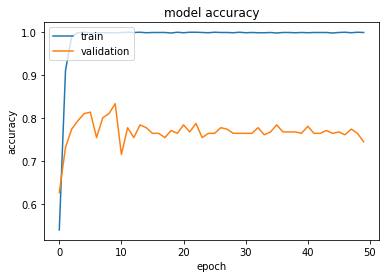

In [19]:
train_accuracy = []
val_accuracy = []
for accs in history_train_acc:
    train_accuracy.append(accs.avg)
for accs in history_val_acc:
    val_accuracy.append(accs.avg)
plt.plot(range(50),train_accuracy)
plt.plot(range(50),val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [20]:
torch.save(best_model_state, "Baseline1_state.tar")
#torch.save(model,"Baseline1&2.pt")

In [ ]:
model.eval()
for X, y in tqdm(val_loader, leave=False):
    inputs = X.cuda()
    outputs = model(inputs)
    print("y actual:",y)
    print(outputs.argmax(dim=1, keepdim=True).view(-1))
    acc = compute_acc(outputs.cpu(), y)
    print(f'Test Acc: {acc}')

y actual: tensor([0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1])
tensor([0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 2, 1, 1, 1], device='cuda:0')
Test Acc: 0.703125
y actual: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 2, 0, 0, 0, 1, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
        0, 0, 1, 0, 0, 2, 0, 0, 1, 1, 1, 2, 1, 0, 1, 2])
tensor([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 1, 1, 2, 1, 1, 0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1, 2, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 2, 1, 0, 1, 1], device='cuda:0')
Test Acc: 0.71875
y actual: tensor([0, 2, 0, 0, 2, 1, 2, 0,

In [21]:
def final_evaluation():
    model.eval()
    accs = AverageMeter()
    for X, y in tqdm(train_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        outputs = model(inputs)
        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
    print("train acc: {:.4f} ".format(accs.avg))
    class_names = ["NIL","MOD","SEV"]
    for i in range(3):
        Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
        Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
        F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
        print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))
        
    accs = AverageMeter()
    for X, y in tqdm(val_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        outputs = model(inputs)
        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
    print("validation acc: {:.4f} ".format(accs.avg))
    class_names = ["NIL","MOD","SEV"]
    for i in range(3):
        Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
        Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
        F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
        print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))

In [22]:
model.load_state_dict(best_model_state)

<All keys matched successfully>

In [ ]:
model.load_state_dict(torch.load("./drive/MyDrive/proj1_data/Baseline1_state.tar"))

<All keys matched successfully>

In [23]:
final_evaluation()

train acc: 0.9983 
class NIL Precision 0.998 Recall1.000 F1 0.999
class MOD Precision 1.000 Recall0.996 F1 0.998
class SEV Precision 0.994 Recall1.000 F1 0.997


validation acc: 0.7451 
class NIL Precision 0.992 Recall0.682 F1 0.809
class MOD Precision 0.520 Recall0.975 F1 0.678
class SEV Precision 0.818 Recall0.545 F1 0.655


## Reports for Baseline1&2

We have tried many models for this project so far, four of us attempted at least 100 times for different combinations. For code simplicity, here we just show our final model for baseline1&2, and we will show our intermediate model results in the presentation. 

***First of all, I have to point out that WE HAVE TRIED the data processing with many techniques and transforms, but on the very last day we find it may not be suitable for this project. Because the accuracy with data-augmentation is way below the accuracy without it. Our conclusion is, the color and direction all matters for this task, we should not randomly flip or jitter the picture, otherwise it will confuse our model. If you do not believe it, you could just uncomment the transforms and run the model for comparison. So we comment nearly all the transforms but PLEASE NOTE we tried many times for this before.***

So for this model, we main utilize the CNN approaches, we have three layers of CNN-batchnormalilzation-activation(relu)-maxpool_layer block and then a flatten layer followed by three fc layers decorated by batchnormalization and relu. And for the baseline2, this is just a self-defined loss function. As you could see in our code.

Our tuning procedure is fairly complicated, I will just give a brief description here. We first built a two-layer CNN+fc, but the accuracy is not good(around 55%), so we think maybe we have too many parameters to train, I tried to make it simpler by reducing the input size of the fc layer but the accuracy turns out to be very weird and it only output one class and stop to improve there. So we think this is not the case and then we want to make our model more complicated, first we added the batchnormalization and then we added lr-scheduler because the validation score is in a huge fluctuation. But still, the accuracy is not high enough, so we decide to add one more layer of both CNN and fc, this time, the accuracy went up to 70%, and finally one day later, we remove the normalization in the database part and remove the unnecessary  transforms and this model's accuracy rocketed to 81.05%.

For baseline 2, we just fine-tune the C in the loss function. we tried with many parameters, first 0.1-1.0 and then 0.01-0.09, and 1-10. we find that 1 is good enough in our case. 

For the precision, recall, and F1 score, We use a function to calculate that, you could see the results above in the output box.

We actually output all the information at each epoch so you could also refer to that.

So this is our report for baseline1&2. 